In [109]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

#%%timeit -n1 -r1

['/device:CPU:0', '/device:GPU:0']


In [110]:
import os
import albumentations

import numpy as np
import pandas as pd
import tensorflow as tf

In [127]:
from glob import glob
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import models

In [112]:
def get_image_labels():
    df = pd.read_csv('C:\\Users\\m7irt\\OneDrive\\Desktop\\NIHCC ChestXray\\Data_Entry_2017.csv')
    
    columns_to_drop = [
        'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]',
        'OriginalImagePixelSpacing[x', 'y]'
    ]
    df = df.drop(columns = columns_to_drop)
    image_label_dict = {}
    
    for row in range(112120):
        image_name = df.iat[row, 0]
        image_name = image_name.strip(".png")
        disease_name = df.iat[row, 1]
        disease_name = disease_name.split("|")
        image_label_dict[image_name] = disease_name
        
    return image_label_dict

In [113]:
def get_image_paths():
    image_paths = {}
    paths = glob(os.path.join('images', '*.png'))
    
    for path in paths:
        image_name = os.path.basename(path)
        image_name = image_name.strip(".png")
        image_paths[image_name] = path
    
    return image_paths

In [114]:
def labels_to_array(image_labels, paths):
    labels = []
    
    for path in paths:
        image_name = os.path.basename(path)
        image_name = image_name.strip(".png")
        labels.append(image_labels[image_name])
        
    return labels

In [115]:
def get_meta_information():
    column_names = ["Image_Name", "Image_Path", "Binary_Image_Labels", "Image_Labels", "Image_Labels_List"]
    indexes = [index for index in range(112120)]
    
    meta_data = pd.DataFrame(index = indexes, columns = column_names)
    
    image_paths = glob(os.path.join('images', '*.png'))
    total_image_samples = len(image_paths)
    image_labels = get_image_labels()
    labels_list = labels_to_array(image_labels, image_paths)
    
    binarizer = MultiLabelBinarizer()
    binary_labels = binarizer.fit_transform(labels_list)
    
    for index in tqdm(range(total_image_samples), desc = "Progress"):
        path = image_paths[index]
        name = os.path.basename(path)
        name = name.strip(".png")
        
        label_binary = binary_labels[index]
        label_string = '|'.join(image_labels[name])
        label_list = labels_list[index]
        
        # Setting value for Image_Name
        column = column_names[0]
        meta_data[column][index] = name
        
        # Setting value for Image_Path
        column = column_names[1]
        meta_data[column][index] = path
        
        # Setting value for Binary_Image_Labels
        column = column_names[2]
        meta_data[column][index] = label_binary
        
        # Setting value for Image_Labels
        column = column_names[3]
        meta_data[column][index] = label_string
        
        # Setting value for Image_Labels_List
        column = column_names[4]
        meta_data[column][index] = label_list
    
    meta_data.to_csv('meta_data.csv')
    return meta_data

In [155]:
def plot_label_count(info):
    class_label_count = {
        'Atelectasis' : 0,
        'Cardiomegaly' : 0,
        'Effusion' : 0,
        'Infiltration' : 0,
        'Mass' : 0,
        'Nodule' : 0,
        'Pneumonia' : 0,
        'Pneumothorax' : 0,
        'Consolidation' : 0,
        'Edema' : 0,
        'Emphysema' : 0,
        'Fibrosis' : 0,
        'Pleural_Thickening' : 0,
        'Hernia' : 0,
        'No Finding' : 0
    }

    for index in range(112120):
        sample_labels = info["Image_Labels_List"][index]
        for disease in sample_labels:
            class_label_count[disease] += 1
            
    labels = list(class_label_count.keys())
    count = list(class_label_count.values())

    fig, ax = plt.subplots(figsize =(12, 5))
    ax.barh(labels, count)
    
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 2)
    ax.yaxis.set_tick_params(pad = 3)
    
    # Add x, y gridlines
    ax.grid(visible = True, color ='grey', linestyle ='-.', linewidth = 0.5, alpha = 0.2)
    
    # Show top values
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(
            i.get_width() + 0.2, 
            i.get_y() + 0.5, 
            str(round((i.get_width()), 2)), 
            fontsize = 10, 
            fontweight = 'bold', 
            color ='grey'
        )
    
    ax.set_title('Samples Belonging to Each Class Label', loc ='center')
    plt.show()
    return class_label_count

In [116]:
dataset_info = get_meta_information()

Progress: 100%|██████████| 112120/112120 [07:37<00:00, 245.30it/s]


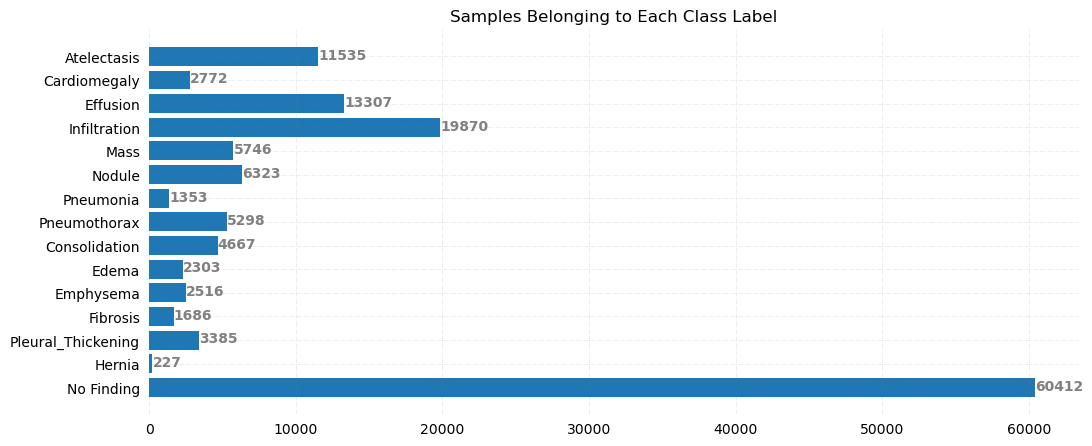

In [156]:
clas_label_count = plot_label_count(dataset_info)

In [117]:
# resnet50_model = ResNet50(
#     include_top = False,
#     weights = 'imagenet',
#     input_tensor = None,
#     input_shape = None,
#     pooling = None,
#     classes = 15,
#     classifier_activation = "softmax"
# )